In [2]:
import pandas as pd
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from node2vec import Node2Vec
from catboost import CatBoostRegressor

# Load Data

In [3]:
# Load edges
edges = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/edges.csv", sep=",") # Подгрузим данные
edges.head(3)

,node_1,node_2
0,344,50
1,344,153
2,344,532


In [4]:
G = nx.from_pandas_edgelist(edges, source="node_1", target="node_2")

In [5]:
# Load train data
train = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/train.csv", sep=",") 
train.head(3)

,target,node
0,0.251968,11142
1,0.689541,2243
2,0.678245,15514


In [6]:
# Load test data
test = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/test.csv", sep=",")
test.head(3)

,target,node
0,0.279231,817
1,0.380795,9574
2,0.686527,1607


# Data Exploration

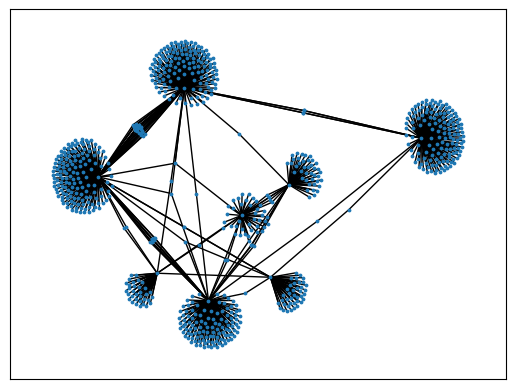

In [7]:
selected_nodes = edges[edges['node_1'].isin(edges['node_1'].unique()[:8])]
graph = nx.from_pandas_edgelist(selected_nodes, source="node_1", target="node_2")
nx.draw_networkx(graph, with_labels=False, node_size=3)

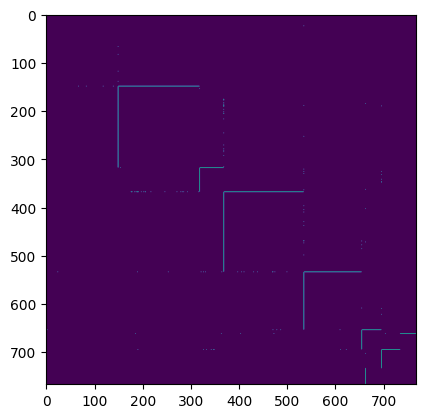

In [8]:
adj_G = nx.to_numpy_array(graph)
plt.imshow(adj_G)

# Simple Features & Random Forest Regressor

In [9]:
def get_node_features(graph, dataset):
  
  cl_coefs = nx.clustering(graph, nodes=dataset['node'])
  dataset['clustering_coef'] = list(cl_coefs.values())

  degree = graph.degree
  dataset['degree'] = dataset['node'].apply(lambda x: degree[x])

  avc = nx.eigenvector_centrality(graph)
  dataset['eigenvector_centrality'] = dataset['node'].apply(lambda x: avc[x])

  return dataset

In [10]:
train_features = get_node_features(G, train)
train_features.head(3)

,target,node,clustering_coef,degree,eigenvector_centrality
0,0.251968,11142,0.118367,50,0.007625
1,0.689541,2243,0.056475,190,0.018495
2,0.678245,15514,0.063171,172,0.010737


In [11]:
RF_regr = RandomForestRegressor()
data = train_features.drop(['node', 'target'], axis=1).to_numpy()
target = train_features['target'].to_numpy()
RF_regr.fit(data, target)

RandomForestRegressor()

In [12]:
test_features = get_node_features(G, test)
test_features.head(3)

,target,node,clustering_coef,degree,eigenvector_centrality
0,0.279231,817,0.025259,70,0.003069
1,0.380795,9574,0.048017,92,0.008070
2,0.686527,1607,0.020455,176,0.008352


In [13]:
# Predict test
test_data = test_features.drop(['node', 'target'], axis=1).to_numpy()
preds = RF_regr.predict(test_data)
true_test = test_features['target'].to_numpy()
mean_squared_error(true_test, preds)

0.015964756282137605

# Node2Vec

In [14]:
node2vec = Node2Vec(G, dimensions=32, walk_length=40, num_walks=100, workers=1)
model = node2vec.fit(window=15, min_count=1)

Computing transition probabilities:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [30:53<00:00, 18.53s/it]


In [15]:
train_embs = pd.DataFrame()
train_embs['vector'] = train['node'].apply(lambda x: model.wv.get_vector(str(x)))

In [16]:
RF_regr = RandomForestRegressor()
data = train_embs['vector'].to_numpy()
data = np.stack(data)
target = train['target'].to_numpy()
RF_regr.fit(data, target)

RandomForestRegressor()

In [17]:
test_embs = pd.DataFrame()
test_embs['vector'] = test['node'].apply(lambda x: model.wv.get_vector(str(x)))

In [18]:
test_data = test_embs['vector'].to_numpy()
test_data = np.stack(test_data)
preds = RF_regr.predict(test_data)
true_test = test['target'].to_numpy()
mean_squared_error(true_test, preds)

0.35555583917742034

# Combine Features

In [22]:
train_features = pd.concat([train_features, pd.DataFrame(data)], axis=1)
train_features.head(3)

,target,node,clustering_coef,degree,eigenvector_centrality,0,1,2,3,4,...,22,23,24,25,26,27,28,29,30,31
0,0.251968,11142,0.118367,50,0.007625,-0.045219,-0.183375,0.090734,-0.050436,-0.187689,...,0.234190,0.193713,0.117991,-0.140031,-0.281326,0.259909,0.241791,-0.248326,0.449021,-0.101534
1,0.689541,2243,0.056475,190,0.018495,0.195168,0.071178,0.113101,0.184466,-0.530832,...,-0.053627,0.030676,-0.029523,-0.236200,-0.072539,0.120411,-0.334290,-0.363228,0.065050,-0.006067
2,0.678245,15514,0.063171,172,0.010737,-0.346384,-0.375680,0.371944,-0.054970,-0.201935,...,0.192794,-0.675958,-0.136089,-0.220511,-0.744989,-0.016471,0.141644,-0.129818,-0.048570,-0.001388


In [ ]:
cat = CatBoostRegressor(loss_function="RMSE")
data = train_features.drop(['node', 'target'], axis=1).to_numpy()
target = train_features['target'].to_numpy()
cat.fit(data, target, plot=True)

In [25]:
test_features = pd.concat([test_features, pd.DataFrame(test_data)], axis=1)

In [36]:
test_data = test_features.drop(['node', 'target'], axis=1).to_numpy()
preds = cat.predict(test_data)
true_test = test_features['target'].to_numpy()
mean_squared_error(true_test, preds)

0.019185562400122688